## Auto-Tuner
I will use this notebook to auto-tune to required configuratios. The CNN classifier will be used to identify the state of the device. This state will be tuned using an optimzer to a required state.

I will do auto-tuning of two types. In both types, it will be focused on the single to double dot transition.
* plunger tuning : The state will be tuned in the two-dimensional space of plunger voltages. This will be done with simulated data.
* central barrier tuning: The state will be tuned in the one-dimensional space of the barrier. This will be be done with experimental data.

In [69]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import scipy.interpolate
import glob

## Loading the trained CNN
I will load the trained CNN into substate_classifier variable.

In [70]:
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

# application logic will be added here
def cnn_model_fn(features,labels,mode):
    '''Model function for CNN'''
    #input layer
    input_layer = tf.cast(tf.reshape(features["x"],[-1,30,30,1]),tf.float32)
    
    conv1 = tf.layers.conv2d(inputs=input_layer,
                            filters=16,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2],strides=2)
    
    conv2 = tf.layers.conv2d(inputs=pool1,
                            filters=16,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],strides=2)
    
    flat = tf.contrib.layers.flatten(inputs=pool2)
    # dense output layer
    out1 = tf.layers.dense(inputs=flat,units=1024,activation=tf.nn.relu)  
    dropout1 = tf.layers.dropout(
      inputs=out1, rate=0.5, training=mode == learn.ModeKeys.TRAIN)
    
    out2 = tf.layers.dense(inputs=dropout1,units=256,activation=tf.nn.relu)  
    dropout2 = tf.layers.dropout(
      inputs=out2, rate=0.5, training=mode == learn.ModeKeys.TRAIN)
    
    out = tf.layers.dense(inputs=dropout2, units=4)
    
    loss = None

    # Calculate loss( for both TRAIN AND EVAL modes)
    if mode != learn.ModeKeys.INFER:
        loss = tf.losses.mean_squared_error(labels=labels, predictions=out)

    # Configure the training op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # Generate predictions
    predictions= {
        "prob" : out,
        "states" : tf.argmax(out,axis=1)
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)


    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=tf.argmax(labels,axis=1), predictions=predictions["states"])}
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

model_dir = "/Users/sandesh/trained_networks/substate_classifier/"
substate_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,model_dir=model_dir)

## 1: Plunger space tuning
I will load data for a full sub-region. One 100x100 map will be used.

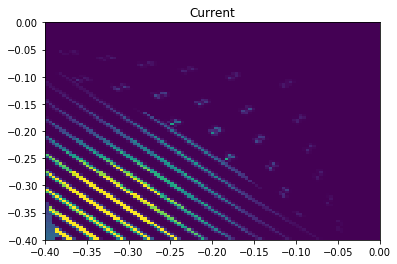

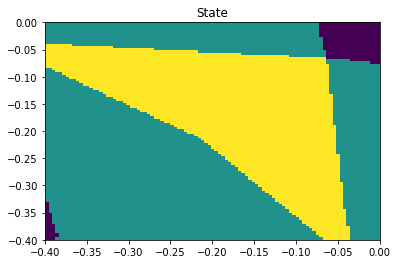

In [71]:
# just load one of the full maps 
files = glob.glob("/Users/sandesh/data/quantum-ml/data_for_paper/double_dot_low_var/*.npy")
index = np.random.randint(len(files))
index = 100
sample_data = np.load(files[index]).item()

V_P1_vec = sample_data['V_P1_vec']
V_P2_vec = sample_data['V_P2_vec']
N_v = len(V_P1_vec)
current = np.array([x['current'] for x in sample_data['output']]).reshape(N_v,N_v)
state = np.array([x['state'] for x in sample_data['output']]).reshape(N_v,N_v)

XX,YY = np.meshgrid(V_P1_vec,V_P2_vec)
plt.figure(1)
plt.pcolor(XX,YY,current,vmax=1e-4)
plt.title("Current")
plt.figure(2)
plt.pcolor(XX,YY,state)
plt.title("State")

### Fitness function
I will define a fitness function which will be the distance between a required prob. vector of a subregion and the prob. vector produced from the CNN.

In [79]:
def fitness(subimage,prob_0,substate_classifer=substate_classifier):
    test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x" : 1e4*subimage},
      y=None,
      num_epochs=1,
      shuffle=False)

    prob = [x['prob'] for x in list(substate_classifier.predict(input_fn = test_input_fn))]
    fitness = np.array([np.linalg.norm(x-prob_0) for x in prob])
    return fitness

In [80]:
def take_subimage(x,y,image,subsize = 30):
    return image[(x-subsize//2):(x+subsize//2),(y-subsize//2):(y+subsize//2)]

Fitness (lower is better) [ 1.09916547]


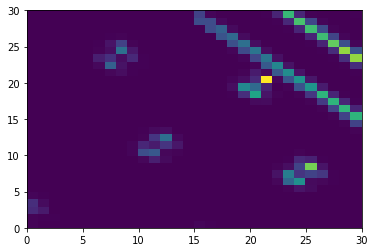

In [81]:
x,y = np.random.randint(15,84,2)
subimage = take_subimage(x,y,current)
plt.pcolor(subimage)

prob_0 = np.array([0,0,1,0])
print("Fitness (lower is better)",fitness(subimage,prob_0))


### Evaluation of fitness function
I will evaluate the fitness function over the full image to see how the landscape looks like.

In [93]:
prob_0 = np.array([0,0,1,0])
subimage_array = np.array([take_subimage(x,y,current) for x in range(15,84) for y in range(15,84)])
fitness_array = np.array(fitness(subimage_array,prob_0))

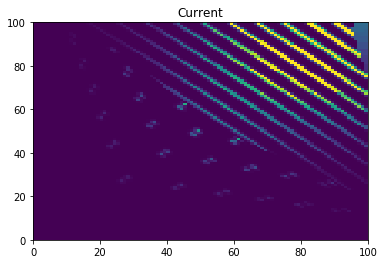

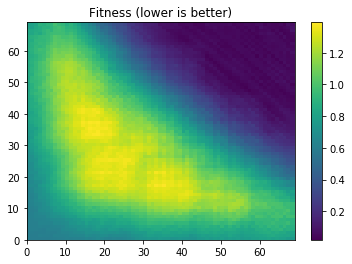

In [98]:
plt.figure(1)
plt.pcolor(current,vmax=1e-4)
plt.title("Current")
plt.figure(2)
plt.pcolor(fitness_array.reshape(-1,int(np.sqrt(fitness_array.shape[0]))))
plt.title("Fitness (lower is better)")
plt.colorbar()